In [4]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

In [5]:
import pickle

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location=('/mnt/c/Users/pratyush_gangwar/OneDrive - EPAM/mywork/MLOPS '
 'Training/ZOOMCAMP/mlops-clsk1709/module2/mlruns/1'), creation_time=1727772601538, experiment_id='1', last_update_time=1727772601538, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
#read parquet file
#Q1 - Download data and get the length of columns -
df_jn = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
#df_fb = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")
len(df_jn.columns)

#ANswer - 19

19

In [8]:
#Q2. Computing durationNow let's compute the duration variable. It should contain the duration of a ride in minutes.
#What's the standard deviation of the trips duration in January?

df_jn['duration'] = df_jn.tpep_dropoff_datetime - df_jn.tpep_pickup_datetime
df_jn['duration'] = df_jn.duration.dt.total_seconds() / 60


In [9]:
df_jn.duration.mean()

np.float64(15.668995167330452)

In [10]:
df_jn.duration.std()

np.float64(42.59435124195458)

In [11]:
len(df_jn[(df_jn.duration >= 1) & (df_jn.duration <= 60)]) / len(df_jn) * 100

98.1220282212598

In [12]:
df_jn = df_jn[(df_jn.duration >= 1) & (df_jn.duration <= 60)].copy()

In [13]:
#Q4. One-hot encoding
#Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
#Fit a dictionary vectorizer
#Get a feature matrix from it
#What's the dimensionality of this matrix (number of columns)?

categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
df_jn[categorical] = df_jn[categorical].astype(str)

train_dicts = df_jn[categorical + numerical].to_dict('records')


In [14]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

In [15]:
print(f'Feature matrix size: {x_train.shape}')

Feature matrix size: (3009173, 516)


In [16]:
#Q5. Training a model
#Train a plain linear regression model with default parameters, where duration is the response variable
#Calculate the RMSE of the model on the training data

target = 'duration'
y_train = df_jn[target].values

LR = LinearRegression()
LR.fit(x_train,y_train)
y_pred = LR.predict(x_train)
mean_squared_error(y_train,y_pred, squared=False)

#Answer  7.649134295950567

/home/pratyush_gangwar/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(7.658405251503513)

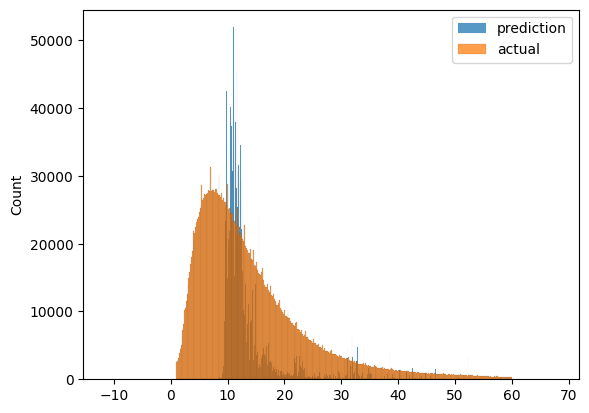

In [17]:
sbn.histplot(y_pred, label='prediction')
sbn.histplot(y_train, label='actual')

plt.legend();

In [18]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [19]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [20]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [21]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [22]:
y_pred = LR.predict(X_val)

In [23]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 7.820378654228158


/home/pratyush_gangwar/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
with mlflow.start_run():
    mlflow.set_tag("Developer","MLflowt1")
    mlflow.log_param("train-data-path","./data/yellow_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","./data/yellow_tripdata_2023-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

/home/pratyush_gangwar/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
